# NN 심화 & Framework

In [160]:
## Module Import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch   #pytorch framework
import torch.nn as nn   # NN 설계와 관련한 함수들 모아 놓은 모듈
import torch.nn.functional as F #torch.nn 중 자주 쓰는 함수들 
import torch.optim as optim
# from torchvision import transforms, datasets

In [161]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [162]:
# Check Device

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

# 사용하는 파이토치 버전, DEVICE 
print('Using Pytorch version:', torch.__version__, 'Device:', DEVICE) 

Using Pytorch version: 1.7.1 Device: cpu


In [193]:
## Import Dataset

# pd.options.display.max_columns  = 785 # 모든 column 들 확인하기 
# 픽셀 column 이름 순서대로되어 있지 않다.. 

train = pd.read_csv('train_df.csv')
test = pd.read_csv('test_df.csv')
sub = pd.read_csv('sample_submission.csv')

display(train.head(), test.head()) # train, test 한꺼번에 display

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,Unnamed: 0,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,57808,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4960,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,35755,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15543,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,48968,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
# Tensor 형태로 변환해주기

train_tensor = torch.FloatTensor(train.iloc[:,1:].values) # label 을 제외한 784개의 pixel 값
train_label_tensor = torch.LongTensor(train['label'].values) # label 값 tensor화
test_tensor = torch.FloatTensor(test.iloc[:,1:].values) # index 제외한 784개의 pixel 값
test_dummy = torch.LongTensor(test['pixel10'].values) # dataloader target variable 있어야 함

train_dataset = torch.utils.data.TensorDataset(train_tensor, train_label_tensor)
test_dataset = torch.utils.data.TensorDataset(test_tensor, test_dummy)

In [195]:
EPOCHS = 10
BATCH_SIZE = 32

In [201]:
# Divide Data to Batches

# 정규화해 불러온 train, test 데이터셋 batch 단위로 분리
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,) # shuffle = True 데이터 순서 섞기

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = BATCH_SIZE)

In [202]:
# Data 확인하기 -> batch 단위로 할당한 데이터의 개수, 형태 확인

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(),'type:', X_train.type())
    print('y_train:', y_train.size(),'type:', y_train.type())
    break
# Batch Size 만큼 데이터가 나누어진 것을 확인할 수 있다 

X_train: torch.Size([32, 784]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [203]:
for (X_test, y_test) in train_loader:
    print('X_train:', X_train.size(),'type:', X_train.type())
    print('y_train:', y_train.size(),'type:', y_train.type())
    break

X_train: torch.Size([32, 784]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [204]:
X_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

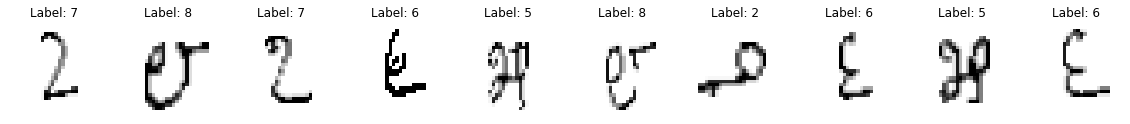

In [205]:
# 이미지 확인하기

size = 2
plt.figure(figsize = (10*size, size))
for idx in range(10): # 처음 10개의 데이터 확인하기
    plt.subplot(1, 10, idx+1) # 한 화면에 여러 개의 그래프(이미지) 그리기
    plt.axis('off') # 이미지만 보이게 axis 제거
    plt.imshow(X_train[idx, :].numpy().reshape(28,28), cmap = "gray_r") # 28*28 픽셀의 이미지
    plt.title('Label: ' + str(y_train[idx].item())) # 각 이미지에 대한 label 값

## Auto Encoder 

In [99]:
## Auto Encoder 
# -> input 데이터에 대한 Hidden Layer로 인코딩(압축) 후 다시 원래 Input Data로 디코딩(복원)
# -> input data를 latent space에 압축시켜 새로운 feature로 사용
# -> 원래 데이터로 잘 복원 = 압축 feature들은 유의미한 feature

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__() # nn.Module 내의 매서드 상속받아 이용

        self.encoder = nn.Sequential( # Sequential() 이용해 인코더 정의
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32)
        )

        # Decoder -> Encoder 에서 생성된 Latent Variable Vector 를 input으로 받는다
        self.decoder = nn.Sequential ( # Sequential() 이용해 디코더 정의
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28)
        )
    
    # Encoder 와 Decoder에 대해 Forward Propagation 정의
    def forward(self, x):
        encoded = self.encoder(x) # Latent Variable Vector 저장
        decoded = self.decoder(encoded) # Latent Variable Vector를 input으로 사용
        return encoded, decoded

In [100]:
# Optimizer 정의하기 

model = AE().to(DEVICE) # Auto Encoder 모델 디바이스에 할당
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) # Adam optimizer 사용, back propagation 통해 parameter 업데이트
criterion = nn.MSELoss() # Auto Encoder의 input image 와 restored image 간의 Mean Squared Error 계산
print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [101]:
# Training Module
def train(model, train_loader, optimizer, log_interval):
    model.train()   #AE 모델 학습 상대로 지정
    #입력 데이터 타깃으로 학습 -> 레이블 데이터 이용할 필요X -> 레이블 값 '_'로 대신 설정해 생략
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.view(-1, 28 * 28).to(DEVICE)    #image data DEVICE에 할당
                                                    #AutoEncoder input 1ckdnjs -> 2차원 이미지 1차원으로 재구성해 할당
        target = image.view(-1, 28 * 28).to(DEVICE)   
        optimizer.zero_grad() #과거에 이용한 데이터로 인해 계산된 loss의 gradient값 초기화
        encoded, decoded = model(image) #image data 이용해 output 계산
        loss = criterion(decoded, target)   #MeanSqaredError 이용해 loss 값 계산
        loss.backward() #Back Propagation 통해 계산된 Gradient값 각 파라미터에 할당
        optimizer.step()    #각 파라미터별 할당된 gradient 값으로 파라미터 업데이트 

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [102]:
# Evaluate Model

def evaluate(model, test_loader):
    model.eval()    #학습 완료된 모델 평가 상태로 지정
    test_loss = 0   #test_loader 내의 데디터로 loss 값 계산
    real_image = [] #AutoEncoder에 이용되는 실제 이미지 저장하는 리스트
    gen_image = []  #AutoEncoder 통해 생성되는 이미지 저장하는 리스트
    with torch.no_grad():   #torch.no_grad(): 모델 평가하는 단계에서 gradient update 일어나지 않게 함
        for image, _ in test_loader:   #batch 내의 이미지 차례대로 접근
            image = image.view(-1, 28 * 28).to(DEVICE)    #28*28크기의 1차원 데이터로 재구성해 할당
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, decoded = model(image) #output 계산

            #AutoEncoder 통해 생성된 이미지와 실제 이미지간의 MeanSquaredError 값 계산 -> test_loss 업데이트
            test_loss += criterion(decoded, image).item()   
            real_image.append(image.to("cpu"))  #실제 이미지 real_image 리스트에 추가
            gen_image.append(decoded.to("cpu")) #생성된 이미지 gen_image 리스트에 추가

    test_loss /= len(test_loader.dataset)    #계산된 test_loss 값 batch 개수만큼 나눠 평균 loss 값 구함
    return test_loss, real_image, gen_image 

Train Epoch: 1 [0/42000 (0%)]	Train Loss: 4390.791016
Train Epoch: 1 [6400/42000 (15%)]	Train Loss: 2362.243896
Train Epoch: 1 [12800/42000 (30%)]	Train Loss: 2203.892334
Train Epoch: 1 [19200/42000 (46%)]	Train Loss: 2093.497559
Train Epoch: 1 [25600/42000 (61%)]	Train Loss: 1946.921387
Train Epoch: 1 [32000/42000 (76%)]	Train Loss: 1849.204834
Train Epoch: 1 [38400/42000 (91%)]	Train Loss: 1851.562622

[EPOCH: 1], 	Test Loss: 61.6086


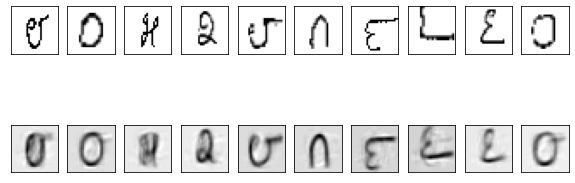

Train Epoch: 2 [0/42000 (0%)]	Train Loss: 2011.441284
Train Epoch: 2 [6400/42000 (15%)]	Train Loss: 2032.055054
Train Epoch: 2 [12800/42000 (30%)]	Train Loss: 2057.100342
Train Epoch: 2 [19200/42000 (46%)]	Train Loss: 1990.437500
Train Epoch: 2 [25600/42000 (61%)]	Train Loss: 1952.352539
Train Epoch: 2 [32000/42000 (76%)]	Train Loss: 2000.485840
Train Epoch: 2 [38400/42000 (91%)]	Train Loss: 1686.582153

[EPOCH: 2], 	Test Loss: 59.3461


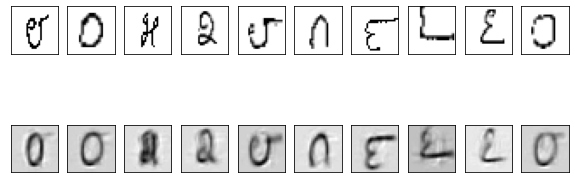

Train Epoch: 3 [0/42000 (0%)]	Train Loss: 1812.871704
Train Epoch: 3 [6400/42000 (15%)]	Train Loss: 2127.937256
Train Epoch: 3 [12800/42000 (30%)]	Train Loss: 1801.663208
Train Epoch: 3 [19200/42000 (46%)]	Train Loss: 1781.205566
Train Epoch: 3 [25600/42000 (61%)]	Train Loss: 1895.033203
Train Epoch: 3 [32000/42000 (76%)]	Train Loss: 1633.227417
Train Epoch: 3 [38400/42000 (91%)]	Train Loss: 1712.494263

[EPOCH: 3], 	Test Loss: 58.6257


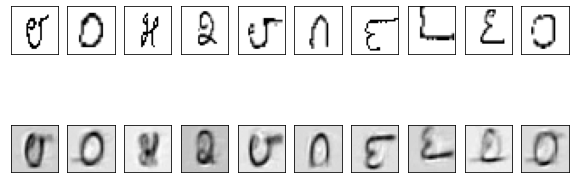

Train Epoch: 4 [0/42000 (0%)]	Train Loss: 1901.808350
Train Epoch: 4 [6400/42000 (15%)]	Train Loss: 1834.294312
Train Epoch: 4 [12800/42000 (30%)]	Train Loss: 1877.609985
Train Epoch: 4 [19200/42000 (46%)]	Train Loss: 1962.547852
Train Epoch: 4 [25600/42000 (61%)]	Train Loss: 1945.475708
Train Epoch: 4 [32000/42000 (76%)]	Train Loss: 1594.468140
Train Epoch: 4 [38400/42000 (91%)]	Train Loss: 1819.008301

[EPOCH: 4], 	Test Loss: 57.7598


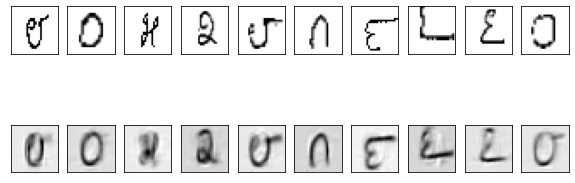

Train Epoch: 5 [0/42000 (0%)]	Train Loss: 1823.763428
Train Epoch: 5 [6400/42000 (15%)]	Train Loss: 1873.081299
Train Epoch: 5 [12800/42000 (30%)]	Train Loss: 2102.717773
Train Epoch: 5 [19200/42000 (46%)]	Train Loss: 1849.553467
Train Epoch: 5 [25600/42000 (61%)]	Train Loss: 1745.673462
Train Epoch: 5 [32000/42000 (76%)]	Train Loss: 1774.966797
Train Epoch: 5 [38400/42000 (91%)]	Train Loss: 1712.841064

[EPOCH: 5], 	Test Loss: 57.7161


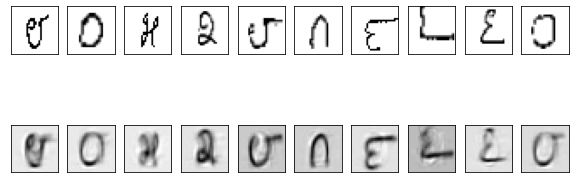

Train Epoch: 6 [0/42000 (0%)]	Train Loss: 1873.715210
Train Epoch: 6 [6400/42000 (15%)]	Train Loss: 1741.616089
Train Epoch: 6 [12800/42000 (30%)]	Train Loss: 1743.461426
Train Epoch: 6 [19200/42000 (46%)]	Train Loss: 1845.655273
Train Epoch: 6 [25600/42000 (61%)]	Train Loss: 2012.763916
Train Epoch: 6 [32000/42000 (76%)]	Train Loss: 1669.188721
Train Epoch: 6 [38400/42000 (91%)]	Train Loss: 1841.775391

[EPOCH: 6], 	Test Loss: 56.5401


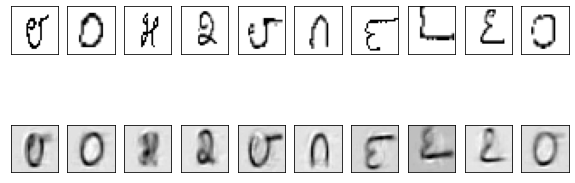

Train Epoch: 7 [0/42000 (0%)]	Train Loss: 1803.263428
Train Epoch: 7 [6400/42000 (15%)]	Train Loss: 1914.625977
Train Epoch: 7 [12800/42000 (30%)]	Train Loss: 1773.577148
Train Epoch: 7 [19200/42000 (46%)]	Train Loss: 2166.050537
Train Epoch: 7 [25600/42000 (61%)]	Train Loss: 1904.735962
Train Epoch: 7 [32000/42000 (76%)]	Train Loss: 1713.962646
Train Epoch: 7 [38400/42000 (91%)]	Train Loss: 1818.109741

[EPOCH: 7], 	Test Loss: 57.0495


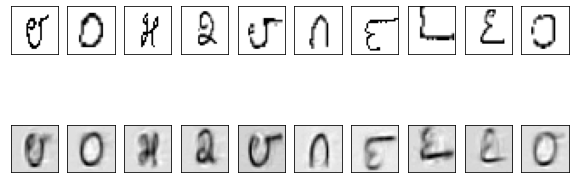

Train Epoch: 8 [0/42000 (0%)]	Train Loss: 1819.723022
Train Epoch: 8 [6400/42000 (15%)]	Train Loss: 1979.839966
Train Epoch: 8 [12800/42000 (30%)]	Train Loss: 1977.549438
Train Epoch: 8 [19200/42000 (46%)]	Train Loss: 1925.506958
Train Epoch: 8 [25600/42000 (61%)]	Train Loss: 1738.120483
Train Epoch: 8 [32000/42000 (76%)]	Train Loss: 1860.881958
Train Epoch: 8 [38400/42000 (91%)]	Train Loss: 1722.932983

[EPOCH: 8], 	Test Loss: 56.8158


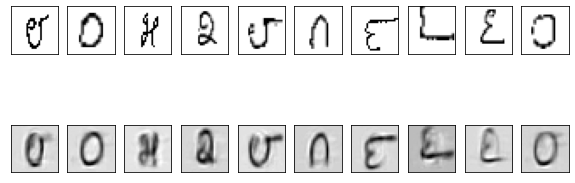

Train Epoch: 9 [0/42000 (0%)]	Train Loss: 2021.705566
Train Epoch: 9 [6400/42000 (15%)]	Train Loss: 1823.918701
Train Epoch: 9 [12800/42000 (30%)]	Train Loss: 1861.779297
Train Epoch: 9 [19200/42000 (46%)]	Train Loss: 1730.339478
Train Epoch: 9 [25600/42000 (61%)]	Train Loss: 1836.692627
Train Epoch: 9 [32000/42000 (76%)]	Train Loss: 1628.811279
Train Epoch: 9 [38400/42000 (91%)]	Train Loss: 1620.595825

[EPOCH: 9], 	Test Loss: 56.7821


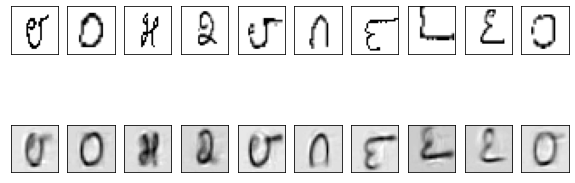

Train Epoch: 10 [0/42000 (0%)]	Train Loss: 1954.842896
Train Epoch: 10 [6400/42000 (15%)]	Train Loss: 1882.442871
Train Epoch: 10 [12800/42000 (30%)]	Train Loss: 1655.658691
Train Epoch: 10 [19200/42000 (46%)]	Train Loss: 1798.565674
Train Epoch: 10 [25600/42000 (61%)]	Train Loss: 1960.911499
Train Epoch: 10 [32000/42000 (76%)]	Train Loss: 1623.137451
Train Epoch: 10 [38400/42000 (91%)]	Train Loss: 1960.629150

[EPOCH: 10], 	Test Loss: 58.8127


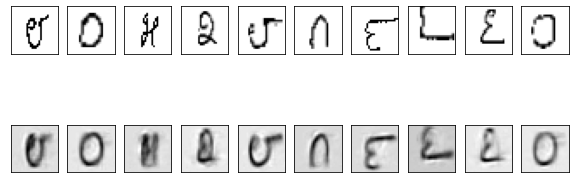

In [103]:
## Model 학습 -> Test set의 Reconstruction Error 확인하기

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize = (10, 4))

    #실제 이미지와 생성된 이미지 비교하며 학습 진행도 확인
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()

Auto Encoder 모델을 이용해 생성된 이미지와 실제 이미지를 출력해 본 결과 원본 이미지와 비슷하게 이미지를 생성하는 것을 확인할 수 있었다.

## Neural Network (Multi Layer Perceptron 모델)
- baseline 코드로 3개의 fully connected layer가 있는 Neural Network를 구성해 학습시켜 보았다. 
- optimizer: Stochastic Gradient Descent 
- activation function: sigmoid -> softmax

In [106]:
class Net(nn.Module):   #PyTorch Moudule 내 딥러닝 모델 관련 기본 함수 포함하는 nn.Module 클래스 상속받는 Net 클래스 정의
    def __init__(self): #Net 클래스의 instance 생성시 지니게 되는 성질 정의
        super(Net, self).__init__() #nn.Module 내의 메서드 상속받아 이용 
        self.fc1 = nn.Linear(28*28, 512)    #첫 번째 Fully Connected Layer
        self.fc2 = nn.Linear(512, 256)      #두 번째 Fully Connected Layer  
        self.fc3 = nn.Linear(256, 10)       #세 번째 Fully Connected Layer
        # (0~9까지 10개의 클래스 표현 위한 라벨 one-hot-encoding)

    def forward(self, x):   #Forward Propagation정의 -> output 계산하기까지 과정 나열
        x = x.view(-1, 28*28)   #2차원 데이터 1차원 데이터로 변형(view 메서드) - 784크기의 1차원 데이터로 변환(flatten)
        x = self.fc1(x)   
        x = F.sigmoid(x)    #sigmoid() 이용해 fc2의 input 계산
        x = self.fc2(x)    
        x = F.sigmoid(x)    #sigmoid() 이용해 fc3의 input 값 계산
        x = self.fc3(x) 
        x = F.log_softmax(x, dim = 1)   #log_softmax 이용해 최종 output 계산
        #softmax 이용해 0~9까지 10개의 클래스에 속할 확률 값 계산 
        #log_softmax -> 일반적인 softmax 보다 Back Propagation 이용해 학습시 loss 값에 대한 gradient값 보다 원활하게 계산(log 함수의 기울기 보다 부드럽게 변화)
        
        return x    #최종 계산된 x 값 output으로 반환

In [107]:
# Optimizer, Objective Function 설정

model = Net().to(DEVICE)    #앞서 정의한 모델을 DEVICE에 할당
#Back Propagation 이용해 파라미터 업데이트시 이용하는 optimizer 정의
#Stochastic Gradient Descent(SGD) 알고리즘 이용, Learning Rate 0.01, Momentum(Optimizer의 관성 나타냄) 0.5
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)  

#MLP 모델의 output 값 + one-hot-encoding값과의 loss Criterion 이용해 계산 
criterion = nn.CrossEntropyLoss()   #nn.CrossEntropyLoss() 로 criterion 설정

print(model)


Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [206]:
# 모델 학습

def train(model, train_loader, optimizer, log_interval):
    model.train()   #MLP 모델을 학습 상대로 지정
    for batch_idx,(image, label) in enumerate(train_loader):   
        image = image.to(DEVICE)    # 이미지 데이터 device에 할당
        label = label.to(DEVICE)    # 레이블 데이터도 device에 할당
        optimizer.zero_grad()       # optimizer의 gradient값을 초기화
        output = model(image)       # output계산
        loss = criterion(output, label) # cross entropy를 이용해 loss 계산
        loss.backward()     #loss계산값을 바탕으로 back propagation -> 계산된 gradient 값 각 parameter에 할당
        optimizer.step()    #각 파라미터에 할당된 graidient값을 이용해 파라미터 값 업데이트

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\t Train Loss: {:.6f}".format(
                Epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. *batch_idx / len(train_loader),
                loss.item()
            ))

In [207]:
## 모델 Test

def evaluate(model, test_loader):
    model.eval()    # 모델을 평가 상태로 지정
    predict = []
    for image, _ in test_loader:    
        image = image.to(DEVICE)    
        output = model(image)       
        prediction = output.max(1, keepdim = False)[1]   # output -> 크기 10인 벡터값
                                                        # 계산된 벡터 값 내 가장 큰 값의 위치에 해당하는 클래스 예측
        predict += prediction.tolist() # predict list에 추가 

    return predict

In [111]:
## Train

EPOCHS = 30
for Epoch in range (1, EPOCHS +1 ):
    train(model, train_loader, optimizer, log_interval = 200)   #train_loaer 학습데이터로 train model 실행, log_interval: 학습 과정 출력 

/42000(91%)]	 Train Loss: 0.001758
Train Epoch: 26 [0/42000(0%)]	 Train Loss: 0.001066
Train Epoch: 26 [6400/42000(15%)]	 Train Loss: 0.005194
Train Epoch: 26 [12800/42000(30%)]	 Train Loss: 0.009823
Train Epoch: 26 [19200/42000(46%)]	 Train Loss: 0.002188
Train Epoch: 26 [25600/42000(61%)]	 Train Loss: 0.004524
Train Epoch: 26 [32000/42000(76%)]	 Train Loss: 0.001546
Train Epoch: 26 [38400/42000(91%)]	 Train Loss: 0.002448
Train Epoch: 27 [0/42000(0%)]	 Train Loss: 0.004686
Train Epoch: 27 [6400/42000(15%)]	 Train Loss: 0.001091
Train Epoch: 27 [12800/42000(30%)]	 Train Loss: 0.001530
Train Epoch: 27 [19200/42000(46%)]	 Train Loss: 0.002220
Train Epoch: 27 [25600/42000(61%)]	 Train Loss: 0.004418
Train Epoch: 27 [32000/42000(76%)]	 Train Loss: 0.001984
Train Epoch: 27 [38400/42000(91%)]	 Train Loss: 0.000858
Train Epoch: 28 [0/42000(0%)]	 Train Loss: 0.001590
Train Epoch: 28 [6400/42000(15%)]	 Train Loss: 0.002278
Train Epoch: 28 [12800/42000(30%)]	 Train Loss: 0.003391
Train Epoch: 2

In [139]:
sub['Category'] = evaluate(model, test_loader)
sub.head()

,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8


In [141]:
sub.to_csv("submission.csv",index=False)

multi perceptron model은 test 데이터에서 0.98161 의 결과를 보여주었다

## Neural Network (version2)
(직전의 NN 모델을 수정해 보다 더 높은 정확도를 얻고자 하였다)

- Activation Function: ReLU
- Weight Initialization: He Uniform Initialization
- Batch Normalization
- Optimizer: Adam
- Dropout

In [208]:
class NewNet(nn.Module):  
    def __init__(self): 
        super(NewNet, self).__init__() 
        self.fc1 = nn.Linear(28*28, 512)    #첫 번째 Fully Connected Layer 
        self.fc2 = nn.Linear(512, 256)      #두 번째 Fully Connected Layer 
        self.fc3 = nn.Linear(256, 10)       #세 번째 Fully Connected Layer (0~9까지 10개의 클래스 표현 위한 라벨 one-hot-encoding)
        self.dropout_prob = 0.5 #50%의 노드에 대해 가중값 계산하지 않음 
        self.batch_norm1 = nn.BatchNorm1d(512) # Batch Normalization
        self.batch_norm2 = nn.BatchNorm1d(256)

    def forward(self, x):   # Forward Propagation -> output 계산하기까지 과정 나열
        x = x.view(-1, 28*28)   #2차원 데이터 1차원 데이터로 변형(flatten)
        x = self.fc1(x) 
        x = self.batch_norm1(x) #activation func 이전에 batch normalization 진행   
        x = F.relu(x)    # 비선형 함수 relu() 이용해 fc2의 input 계산

        x = F.dropout(x, training = self.training, p = self.dropout_prob)   # dropout 적용

        x = self.fc2(x)  
        x = self.batch_norm2(x) #activation func 이전에 batch normalization 진행  
        x = F.relu(x)    # relu() 이용해 fc3의 input 값 계산

        x = F.dropout(x, training = self.training, p = self.dropout_prob)

        x = self.fc3(x)    
        x = F.log_softmax(x, dim = 1)   # log_softmax 이용해 최종 output 계산
        #softmax 이용해 0~9까지 10개의 클래스에 속할 확률 값 계산 
        
        return x    #최종 계산된 x 값 output으로 반환

In [209]:
# Weight Initilization 
import torch.nn.init as init    #weight, bias 등 딥러닝 모델에서 초기값으로 설정되는 요소에 대한 모듈 init import
def weight_init(m): #weight 초기화할 부분 설정하는 weight_init 함수
    if isinstance(m, nn.Linear):    # nn.Linear에 해당하는 파라미터들에 대해서만
        init.kaiming_uniform_(m.weight.data)    #nn.Linear 파라미터들에 대해 he_initialization 이용해 파라미터 초기화
        #kaiming_uniform_ : 'He Initialization'

In [210]:
## Optimizer, Objective Function 설정하기

model2 = NewNet().to(DEVICE)    # 모델을 DEVICE에 할당
model2.apply(weight_init)    #모델 weight 초기화

optimizer = torch.optim.Adam(model2.parameters(), lr = 0.01) # Adam optimizer: RMSProp과 Momentum의 특징 결합, 가장 자주 쓰임

# output 값 + one-hot-encoding값과의 loss Criterion 이용해 계산 
criterion = nn.CrossEntropyLoss()   

print(model2)

NewNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [211]:
## Train

EPOCHS = 50
for Epoch in range (1, EPOCHS +1 ):
    train(model2, train_loader, optimizer, log_interval = 200)   #train_loaer 학습데이터로 train model 실행, log_interval: 학습 과정 출력 

/42000(91%)]	 Train Loss: 0.012449
Train Epoch: 46 [0/42000(0%)]	 Train Loss: 0.015907
Train Epoch: 46 [6400/42000(15%)]	 Train Loss: 0.000246
Train Epoch: 46 [12800/42000(30%)]	 Train Loss: 0.047997
Train Epoch: 46 [19200/42000(46%)]	 Train Loss: 0.000847
Train Epoch: 46 [25600/42000(61%)]	 Train Loss: 0.000352
Train Epoch: 46 [32000/42000(76%)]	 Train Loss: 0.002078
Train Epoch: 46 [38400/42000(91%)]	 Train Loss: 0.001446
Train Epoch: 47 [0/42000(0%)]	 Train Loss: 0.000329
Train Epoch: 47 [6400/42000(15%)]	 Train Loss: 0.005112
Train Epoch: 47 [12800/42000(30%)]	 Train Loss: 0.019428
Train Epoch: 47 [19200/42000(46%)]	 Train Loss: 0.031102
Train Epoch: 47 [25600/42000(61%)]	 Train Loss: 0.000519
Train Epoch: 47 [32000/42000(76%)]	 Train Loss: 0.062332
Train Epoch: 47 [38400/42000(91%)]	 Train Loss: 0.000562
Train Epoch: 48 [0/42000(0%)]	 Train Loss: 0.000314
Train Epoch: 48 [6400/42000(15%)]	 Train Loss: 0.001494
Train Epoch: 48 [12800/42000(30%)]	 Train Loss: 0.008867
Train Epoch: 4

In [212]:
sub['Category'] = evaluate(model2, test_loader)
sub.head()

,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8


In [213]:
sub.to_csv("submission3.csv",index=False)